In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

from sarix import sarix
import numpy as np
import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import covidcast
from datetime import date

In [2]:
def load_data(geo_values = "ma", as_of = None, end_day = "2021-07-01"):
    """
    Load data for Change healthcare CLI, cases, and hosps from covidcast
    
    Parameters
    ----------
    as_of: string of date in YYYY-MM-DD format.
        Default to None.
    end_day: string of date in YYYY-MM-DD format.
        Default to "2021-07-01"
    
    Returns
    -------
    df: data frame
        It has columns location, date, inc_hosp, population and rate.
        It is sorted by location and date columns in ascending order.
    """
    # load hospitalizations
    hosp_df = covidcast.signal(data_source="hhs",
                               signal="confirmed_admissions_covid_1d",
                               start_day=date.fromisoformat("2020-10-01"),
                               end_day=date.fromisoformat(end_day),
                               geo_type="state",
                               geo_values=geo_values,
                               as_of=as_of)
    hosp_df = hosp_df[["geo_value", "time_value", "value"]]
    hosp_df.columns = ["location", "date", "hosp"]
    
    # load cases
    case_df = covidcast.signal(data_source="jhu-csse",
                          signal="confirmed_incidence_num",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values=geo_values,
                          as_of=None)
    case_df = case_df[["geo_value", "time_value", "value"]]
    case_df.columns = ["location", "date", "case"]
    
    # load cases
    change_cli_df = covidcast.signal(data_source="chng",
                          signal="smoothed_outpatient_cli",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values=geo_values,
                          as_of=None)
    change_cli_df = change_cli_df[["geo_value", "time_value", "value"]]
    change_cli_df.columns = ["location", "date", "change_cli"]
    
    # merge
    df = case_df.merge(hosp_df, on=["location", "date"], how = "left") \
        .merge(change_cli_df, on=["location", "date"], how = "left")

    # sort
    df = df.sort_values(['location', 'date'])

    return df

df = load_data(geo_values = ["ma", "ca", "pa"], end_day="2021-06-01")
df

,location,date,case,hosp,change_cli
0,ca,2020-10-01,3506.0,316.0,4.929400
3,ca,2020-10-02,4148.0,328.0,4.970151
6,ca,2020-10-03,4257.0,294.0,5.390648
9,ca,2020-10-04,2785.0,315.0,6.488778
12,ca,2020-10-05,1853.0,347.0,6.343796
...,...,...,...,...,...
719,pa,2021-05-28,1066.0,119.0,1.439242
722,pa,2021-05-29,842.0,102.0,1.312694
725,pa,2021-05-30,516.0,94.0,1.375940
728,pa,2021-05-31,421.0,90.0,1.513397


In [3]:
# helper function to plot all signals by location
def plot_by_loc(df, var_names):
  locs = df.location.unique()
  num_locs = len(locs)
  num_vars = len(var_names)
  fig, ax = plt.subplots(num_vars, num_locs, figsize = (num_locs * 4, num_vars * 2), squeeze=False)
  for i, var_name in enumerate(var_names):
    for j, loc in enumerate(locs):
      ax[i, j].plot(df[df.location == loc][[var_name]])
      ax[i, j].title.set_text(loc + ', ' + var_name)
  
  plt.tight_layout()

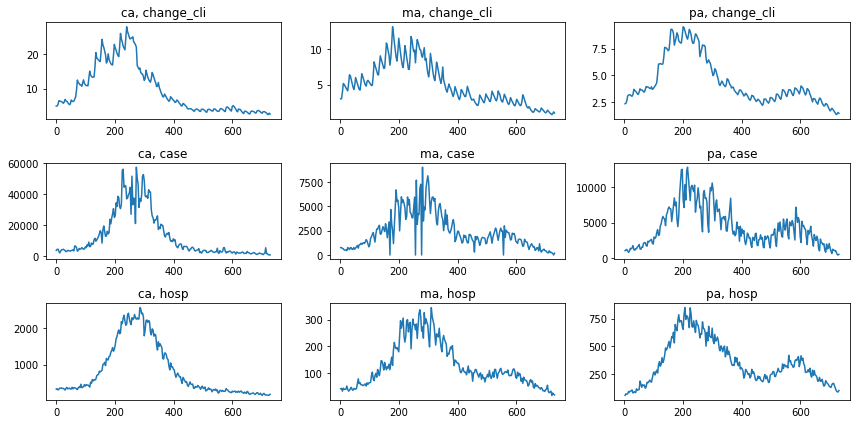

In [4]:
plot_by_loc(df, ['change_cli', 'case', 'hosp'])

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


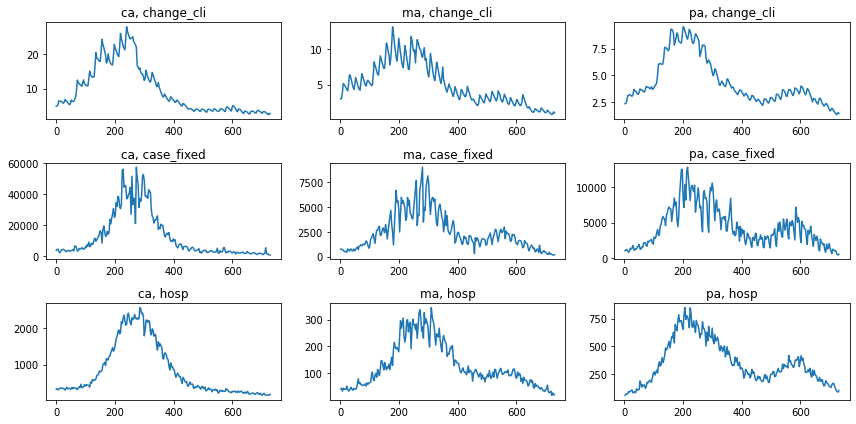

In [5]:
# quick fix to zero values; mean of adjacent
df['case_fixed'] = df.case
zero_inds = np.where(df.case == 0)
df['case_fixed'].iloc[zero_inds] = 0.5 * (df['case_fixed'].iloc[zero_inds[0] - 1].values + df['case_fixed'].iloc[zero_inds[0] + 1].values)
plot_by_loc(df, ['change_cli', 'case_fixed', 'hosp'])

In [117]:
# helper function to plot forecasts
def plot_forecasts(model_fit, var_names):
    T_orig = model_fit.xy_orig.shape[0]
    T = model_fit.xy.shape[0]
    t_orig = np.arange(T_orig)
    t_transformed = np.arange(T) + T_orig - T
    t_pred = T_orig + np.arange(model_fit.forecast_horizon)
    
    percentile_levels = [2.5, 97.5]
    median_prediction = np.median(model_fit.predictions_modeled_scale, axis=0)
    percentiles = np.percentile(model_fit.predictions_modeled_scale, percentile_levels, axis=0)
    median_prediction_orig = np.median(model_fit.predictions, axis=0)
    percentiles_orig = np.percentile(model_fit.predictions, percentile_levels, axis=0)
    
    fig, ax = plt.subplots(2 * len(var_names), 1, figsize=(10,3 * 2 * len(var_names)))
    
    for (i, var_name) in enumerate(var_names):
        ax[0 + i*2].fill_between(t_pred, percentiles_orig[0, :, i], percentiles_orig[1, :, i], color='lightblue')
        ax[0 + i*2].plot(t_pred, median_prediction_orig[:, i], 'blue', ls='solid', lw=2.0)
        ax[0 + i*2].plot(t_orig, model_fit.xy_orig[:, i], 'black', ls='solid')
        ax[0 + i*2].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")
        
        ax[1 + i*2].fill_between(t_pred, percentiles[0, :, i], percentiles[1, :, i], color='lightblue')
        ax[1 + i*2].plot(t_pred, median_prediction[:, i], 'blue', ls='solid', lw=2.0)
        ax[1 + i*2].plot(t_transformed, model_fit.xy[:, i], 'black', ls='solid')
        ax[1 + i*2].set(xlabel="t", ylabel=var_name + " (" + model_fit.transform + " scale)", title="Mean predictions with 95% CI")
    
    plt.tight_layout()
    plt.show()


In [123]:
# quick reload for debug
from importlib import reload
sarix = reload(sarix)

In [121]:
df_ma = df[df.location == 'ma']
sarix_fit_hosp_only = sarix.SARIX(
    xy = df_ma[["hosp"]].values[:-50],
    p = 3,
    d = 0,
    P = 0,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)


sample: 100%|██████████| 2000/2000 [00:04<00:00, 447.62it/s, 127 steps of size 2.04e-02. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.13      0.01      0.13      0.12      0.14    707.02      1.01
   theta[0]      0.75      0.07      0.75      0.63      0.85    580.62      1.00
   theta[1]     -0.00      0.09     -0.01     -0.15      0.15    471.79      1.00
   theta[2]      0.26      0.07      0.26      0.15      0.37    566.11      1.00
theta_sd[0]      0.66      0.36      0.56      0.24      1.11    411.06      1.00

Number of divergences: 0

MCMC elapsed time: 4.609605073928833
batch_shape_x
()
batch_shape_dx
(1000,)


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/4036441017.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


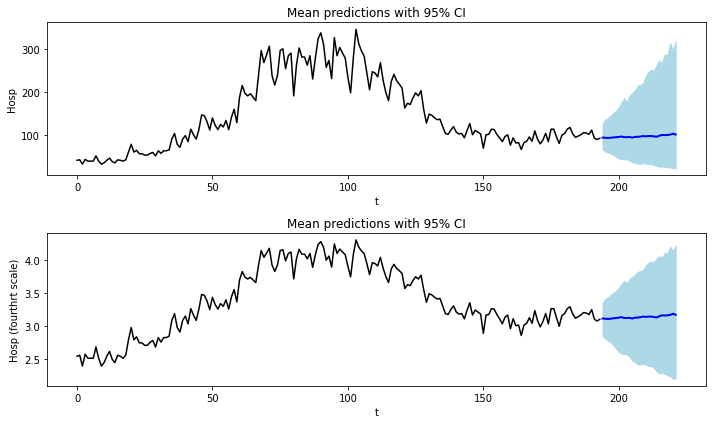

In [122]:
plot_forecasts(sarix_fit_hosp_only, ['Hosp'])

In [124]:
sarix_fit_cases = sarix.SARIX(
    xy = df_ma[["case_fixed", "hosp"]].values[:-50],
    p = 14,
    d = 0,
    P = 0,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:15<00:00, 125.82it/s, 511 steps of size 6.45e-03. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.41      0.02      0.41      0.37      0.44   1099.94      1.00
   sigma[1]      0.10      0.01      0.10      0.09      0.11    725.85      1.00
   theta[0]      0.38      0.07      0.38      0.27      0.48    782.78      1.00
   theta[1]      0.16      0.07      0.16      0.04      0.26    909.54      1.00
   theta[2]      0.02      0.07      0.02     -0.09      0.12    855.58      1.00
   theta[3]      0.09      0.07      0.09     -0.02      0.21    768.92      1.00
   theta[4]      0.11      0.07      0.11     -0.00      0.23    778.91      1.00
   theta[5]      0.18      0.07      0.18      0.08      0.31    644.20      1.00
   theta[6]      0.36      0.07      0.36      0.25      0.49    668.19      1.01
   theta[7]      0.02      0.07      0.03     -0.09      0.14    798.87      1.00
   theta[8]     -0.17      0.07     -0.17     -0.29     -0.06    676.76      1.00
   theta[9]    

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/4036441017.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


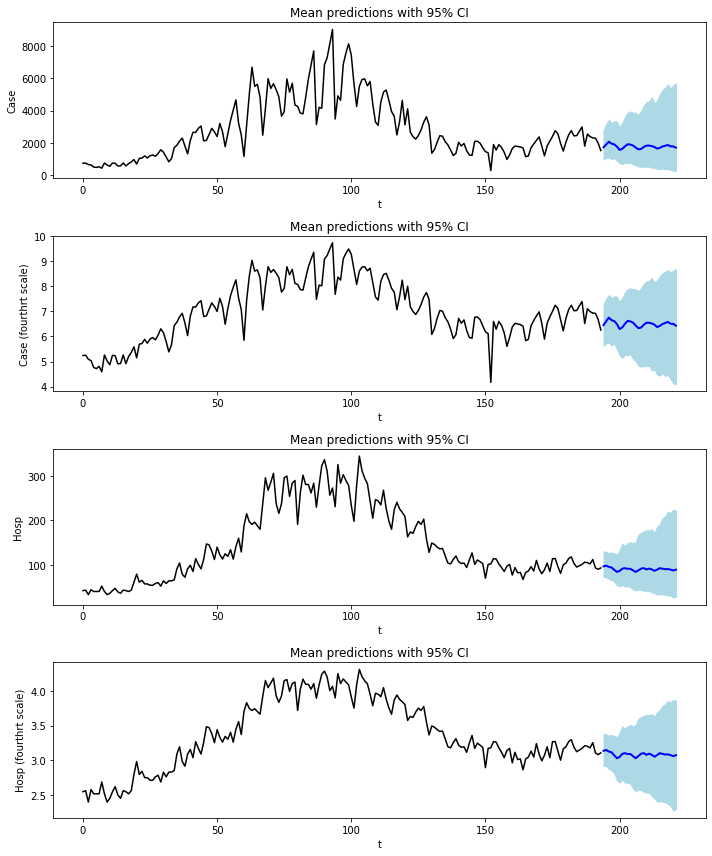

In [125]:
plot_forecasts(sarix_fit_cases, ['Case', 'Hosp'])

In [126]:
sarix_fit_cli_cases = sarix.SARIX(
    xy = df_ma[["change_cli", "case_fixed", "hosp"]].values[:-50],
    p = 2,
    d = 0,
    P = 1,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:15<00:00, 127.42it/s, 1023 steps of size 6.65e-03. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.03      0.00      0.03      0.02      0.03    949.66      1.00
   sigma[1]      0.42      0.02      0.42      0.38      0.45   1149.99      1.00
   sigma[2]      0.11      0.01      0.11      0.10      0.11    872.16      1.00
   theta[0]      1.02      0.07      1.02      0.90      1.14    407.06      1.00
   theta[1]     -0.12      0.07     -0.12     -0.24      0.01    432.21      1.00
   theta[2]      0.81      0.04      0.81      0.75      0.88    957.37      1.00
   theta[3]     -0.73      0.08     -0.73     -0.87     -0.60    431.28      1.00
   theta[4]      0.02      0.07      0.02     -0.09      0.14    409.69      1.00
   theta[5]      0.47      0.07      0.47      0.36      0.59    755.96      1.00
   theta[6]      0.24      0.07      0.24      0.12      0.35    780.16      1.00
   theta[7]      0.60      0.06      0.60      0.51      0.71   1129.81      1.00
   theta[8]    

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/4036441017.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


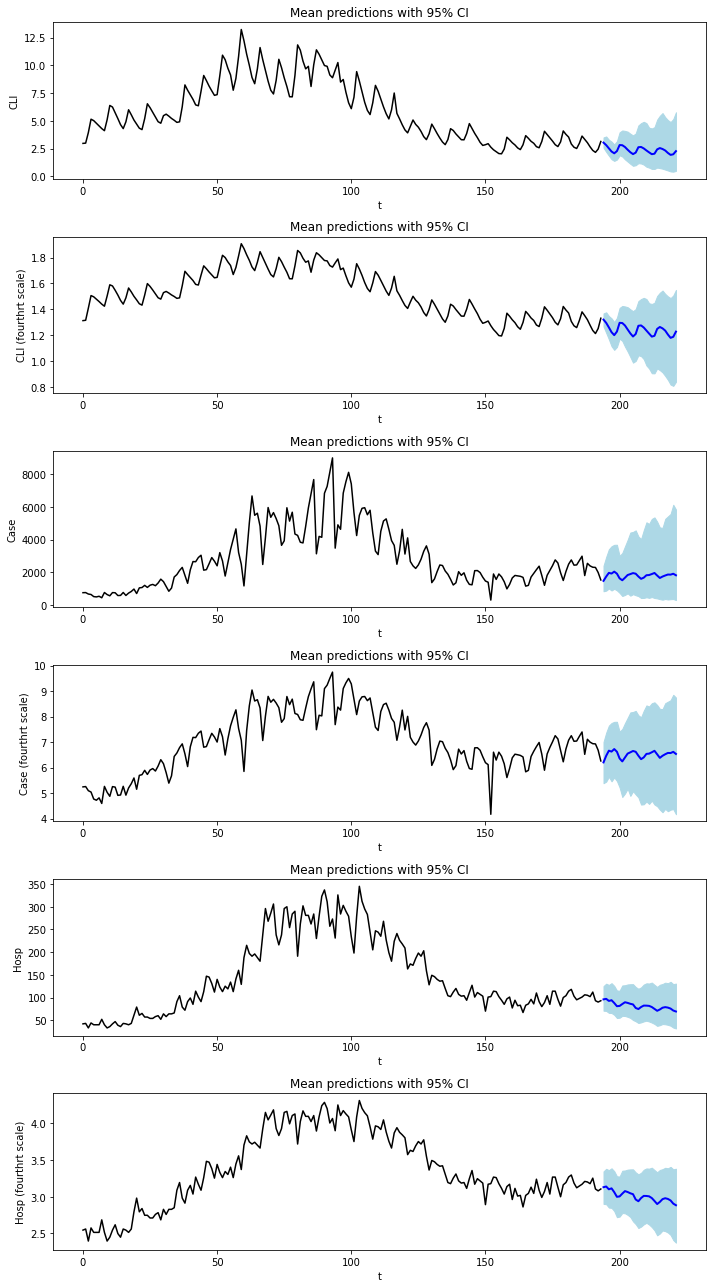

In [127]:
plot_forecasts(sarix_fit_cli_cases, ['CLI', 'Case', 'Hosp'])

In [128]:
sarix_fit_cli_cases_differenced = sarix.SARIX(
    xy = df_ma[["change_cli", "case_fixed", "hosp"]].values[:-50],
    p = 2,
    d = 0,
    P = 1,
    D = 1,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 426.41it/s, 31 steps of size 1.70e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.03      0.00      0.03      0.02      0.03   1195.55      1.00
   sigma[1]      0.44      0.02      0.44      0.40      0.48   1792.70      1.00
   sigma[2]      0.11      0.01      0.11      0.10      0.12   1213.39      1.00
   theta[0]      0.97      0.07      0.97      0.85      1.09    820.35      1.00
   theta[1]     -0.02      0.08     -0.02     -0.14      0.12    809.10      1.01
   theta[2]     -0.39      0.07     -0.39     -0.50     -0.27   1579.54      1.00
   theta[3]      0.33      0.10      0.32      0.18      0.49    869.87      1.00
   theta[4]     -0.01      0.07     -0.01     -0.13      0.11    936.96      1.00
   theta[5]      0.33      0.07      0.33      0.21      0.44   1381.76      1.00
   theta[6]      0.29      0.07      0.29      0.17      0.41   1222.30      1.00
   theta[7]     -0.26      0.07     -0.26     -0.38     -0.14   1619.97      1.00
   theta[8]    

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/4036441017.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


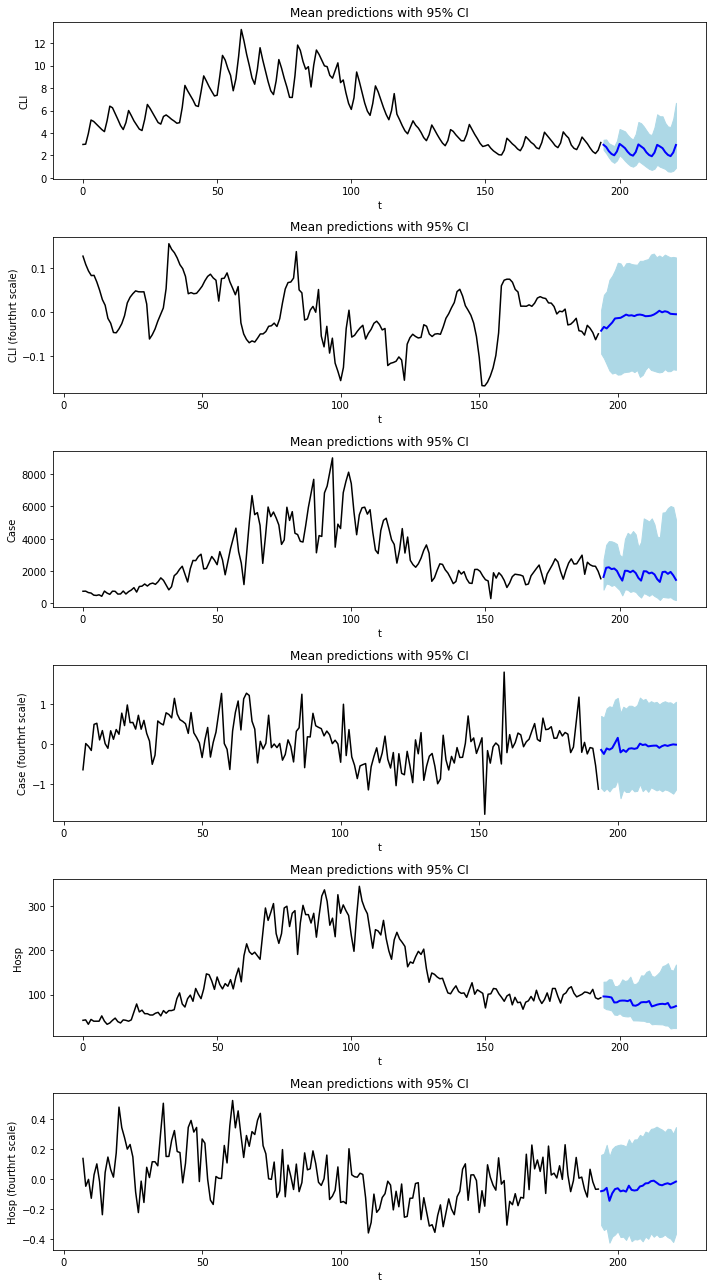

In [129]:
plot_forecasts(sarix_fit_cli_cases_differenced, ['CLI', 'Case', 'Hosp'])

sample: 100%|██████████| 2000/2000 [00:06<00:00, 321.13it/s, 511 steps of size 1.01e-02. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.11      0.01      0.11      0.10      0.12    828.42      1.00
   theta[0]      0.63      0.06      0.62      0.52      0.72    524.34      1.00
   theta[1]      0.36      0.07      0.36      0.27      0.48    549.60      1.00
   theta[2]      0.57      0.06      0.57      0.48      0.67    704.59      1.00
   theta[3]     -0.19      0.07     -0.19     -0.32     -0.08    531.45      1.00
   theta[4]     -0.37      0.06     -0.37     -0.47     -0.26    528.74      1.00
theta_sd[0]      0.58      0.23      0.53      0.27      0.90    469.94      1.00

Number of divergences: 0

MCMC elapsed time: 6.810051918029785


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/4036441017.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


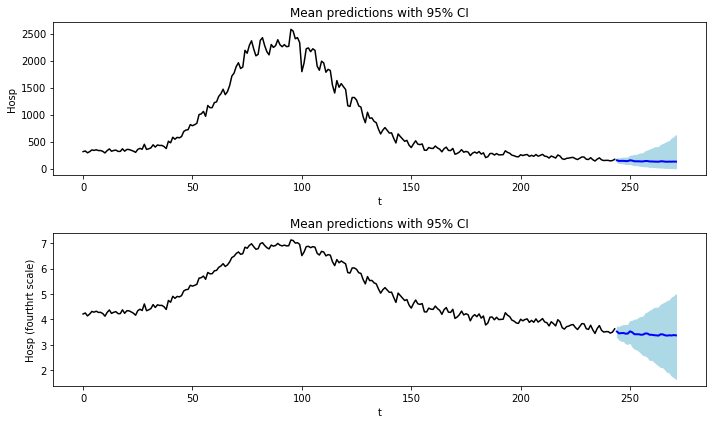

In [133]:
df_ca = df[df.location == 'ca']
sarix_fit_cli_cases_differenced_ca = sarix.SARIX(
    # xy = df_ca[["change_cli", "case_fixed", "hosp"]].values[:-50],
    xy = df_ca[["hosp"]].values,
    p = 2,
    d = 0,
    P = 1,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)
plot_forecasts(sarix_fit_cli_cases_differenced_ca, ['Hosp'])


# Simultaneous fits to multiple locations

We need to organize the data into the shape `(L, T, n_x + 1)` where `L` is the number of locations, `T` is the number of time points, and `n_x + 1` is the total number of time series including covariates `x` and the response `y`. We can opt to share parameters across locations or estimate them separately per location.

In [134]:
df

,location,date,case,hosp,change_cli,case_fixed
0,ca,2020-10-01,3506.0,316.0,4.929400,3506.0
3,ca,2020-10-02,4148.0,328.0,4.970151,4148.0
6,ca,2020-10-03,4257.0,294.0,5.390648,4257.0
9,ca,2020-10-04,2785.0,315.0,6.488778,2785.0
12,ca,2020-10-05,1853.0,347.0,6.343796,1853.0
...,...,...,...,...,...,...
719,pa,2021-05-28,1066.0,119.0,1.439242,1066.0
722,pa,2021-05-29,842.0,102.0,1.312694,842.0
725,pa,2021-05-30,516.0,94.0,1.375940,516.0
728,pa,2021-05-31,421.0,90.0,1.513397,421.0


In [135]:
len(df.date.unique())

244

In [161]:
# quick reload for debug
from importlib import reload
sarix = reload(sarix)

In [162]:
batched_xy = df[["change_cli", "case_fixed", "hosp"]].values.reshape(3, 244, 3)
sarix_fit_all_locs_no_pooling = sarix.SARIX(
    xy = batched_xy,
    p = 2,
    d = 0,
    P = 1,
    D = 1,
    season_period = 7,
    transform = "fourthrt",
    theta_pooling='none',
    sigma_pooling='none',
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:09<00:00, 214.65it/s, 31 steps of size 1.02e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 sigma[0,0]      0.02      0.00      0.02      0.02      0.02   1323.41      1.00
 sigma[0,1]      0.63      0.03      0.63      0.57      0.67   1131.23      1.00
 sigma[0,2]      0.10      0.00      0.10      0.09      0.11   1216.60      1.00
 sigma[1,0]      0.02      0.00      0.02      0.02      0.03   1505.12      1.00
 sigma[1,1]      0.42      0.02      0.41      0.38      0.45   1308.63      1.00
 sigma[1,2]      0.12      0.01      0.12      0.11      0.13   1023.25      1.00
 sigma[2,0]      0.01      0.00      0.01      0.01      0.02   1772.38      1.00
 sigma[2,1]      0.38      0.02      0.37      0.34      0.40   1554.14      1.00
 sigma[2,2]      0.11      0.01      0.11      0.10      0.12   1482.94      1.00
 theta[0,0]      1.28      0.06      1.28      1.17      1.39    605.62      1.00
 theta[0,1]     -0.28      0.07     -0.28     -0.38     -0.15    520.49      1.00
 theta[0,2]    

In [155]:
# helper function to plot forecasts
def plot_batched_forecasts(model_fit, var_names):
    L = model_fit.xy_orig.shape[0]
    T_orig = model_fit.xy_orig.shape[-2]
    T = model_fit.xy.shape[-2]
    t_orig = np.arange(T_orig)
    t_transformed = np.arange(T) + T_orig - T
    t_pred = T_orig + np.arange(model_fit.forecast_horizon)
    
    fig, ax = plt.subplots(2 * len(var_names), L, figsize=(10,3 * 2 * len(var_names)), squeeze=False)
    
    for l in range(L):
        percentile_levels = [2.5, 97.5]
        median_prediction = np.median(model_fit.predictions_modeled_scale[..., l, :, :], axis=0)
        percentiles = np.percentile(model_fit.predictions_modeled_scale[..., l, :, :], percentile_levels, axis=0)
        median_prediction_orig = np.median(model_fit.predictions[..., l, :, :], axis=0)
        percentiles_orig = np.percentile(model_fit.predictions[..., l, :, :], percentile_levels, axis=0)
        
        for (i, var_name) in enumerate(var_names):
            ax[0 + i*2, l].fill_between(t_pred, percentiles_orig[0, :, i], percentiles_orig[1, :, i], color='lightblue')
            ax[0 + i*2, l].plot(t_pred, median_prediction_orig[:, i], 'blue', ls='solid', lw=2.0)
            ax[0 + i*2, l].plot(t_orig, model_fit.xy_orig[l, :, i], 'black', ls='solid')
            ax[0 + i*2, l].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")
            
            ax[1 + i*2, l].fill_between(t_pred, percentiles[0, :, i], percentiles[1, :, i], color='lightblue')
            ax[1 + i*2, l].plot(t_pred, median_prediction[:, i], 'blue', ls='solid', lw=2.0)
            ax[1 + i*2, l].plot(t_transformed, model_fit.xy[l, :, i], 'black', ls='solid')
            ax[1 + i*2, l].set(xlabel="t", ylabel=var_name + " (" + model_fit.transform + " scale)", title="Mean predictions with 95% CI")
    
    plt.tight_layout()
    plt.show()


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/3014073505.py:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


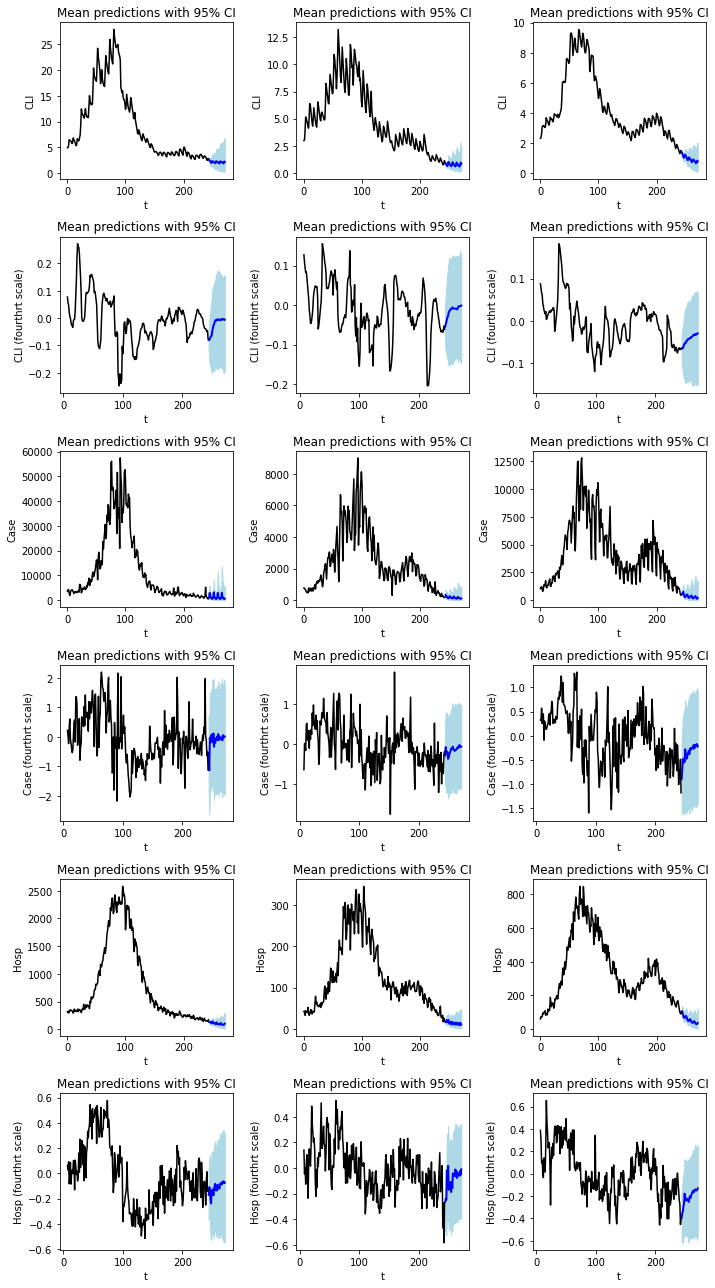

In [163]:
plot_batched_forecasts(sarix_fit_all_locs_no_pooling, ['CLI', 'Case', 'Hosp'])

With autoregressive parameters shared across locations, but separate variance estimates per location:

sample: 100%|██████████| 2000/2000 [00:06<00:00, 291.14it/s, 31 steps of size 1.20e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 sigma[0,0]      0.02      0.00      0.02      0.02      0.02   1321.55      1.00
 sigma[0,1]      0.63      0.03      0.63      0.58      0.68   1360.09      1.00
 sigma[0,2]      0.10      0.00      0.10      0.09      0.11   1326.05      1.00
 sigma[1,0]      0.02      0.00      0.02      0.02      0.03   1677.98      1.00
 sigma[1,1]      0.42      0.02      0.42      0.38      0.45   1302.36      1.00
 sigma[1,2]      0.12      0.01      0.12      0.11      0.13   1288.17      1.00
 sigma[2,0]      0.01      0.00      0.01      0.01      0.02   1365.78      1.00
 sigma[2,1]      0.37      0.02      0.37      0.34      0.40   1230.05      1.00
 sigma[2,2]      0.11      0.01      0.11      0.10      0.12   1284.88      1.00
   theta[0]      1.21      0.04      1.21      1.15      1.27    623.03      1.00
   theta[1]     -0.22      0.04     -0.22     -0.29     -0.16    566.20      1.00
   theta[2]    

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_92552/3014073505.py:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


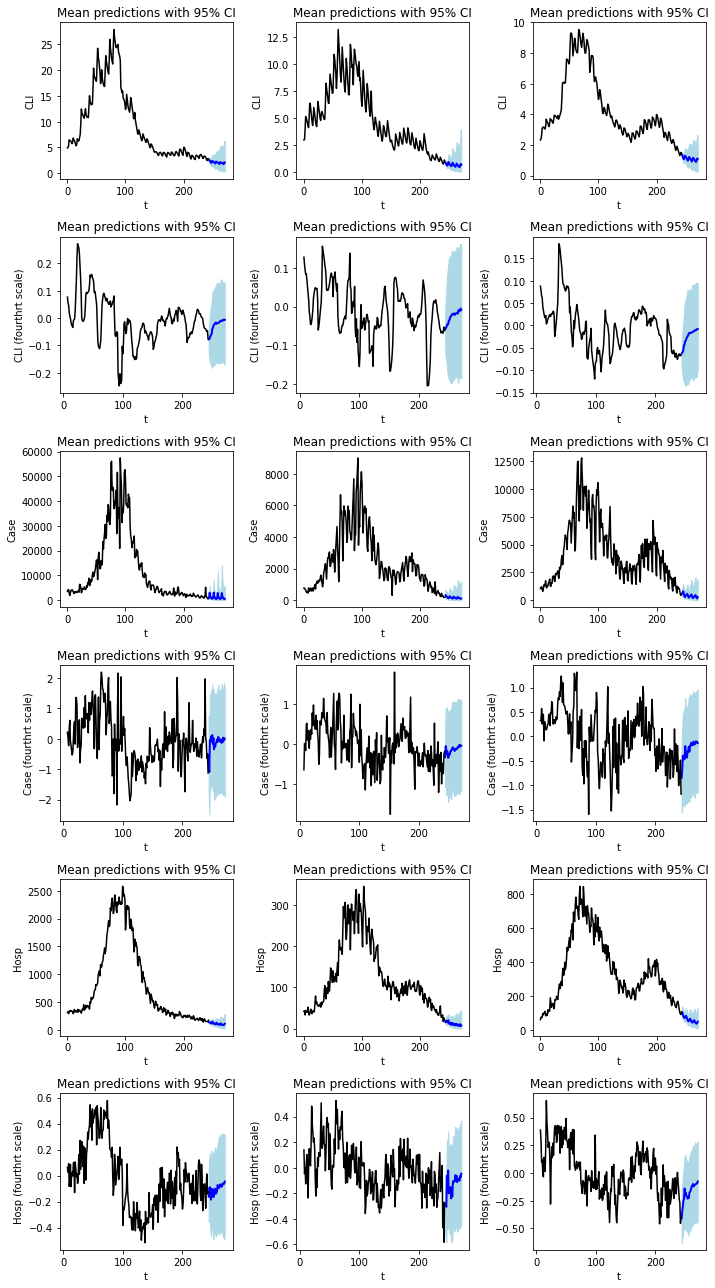

In [164]:
batched_xy = df[["change_cli", "case_fixed", "hosp"]].values.reshape(3, 244, 3)
sarix_fit_all_locs_theta_pooled = sarix.SARIX(
    xy = batched_xy,
    p = 2,
    d = 0,
    P = 1,
    D = 1,
    season_period = 7,
    transform = "fourthrt",
    theta_pooling='shared',
    sigma_pooling='none',
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

plot_batched_forecasts(sarix_fit_all_locs_theta_pooled, ['CLI', 'Case', 'Hosp'])